In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline

Using TensorFlow backend.
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/trentonbricken/anacond

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
import sys
sys.path.insert(1, '/Users/trentonbricken/protein-generators/deep_boltzmann/deep_boltzmann')

In [4]:
pwd

'/Users/trentonbricken/protein-generators/notebooks'

In [5]:
from PlottingFunctions import *

In [6]:
rcParams.update({'font.size': 16})

In [7]:
#%load_ext autoreload
#%autoreload 2

In [8]:
import os
os.chdir('../deep_boltzmann')

In [9]:
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [10]:
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import softmax

AA_num=20 # ignoring spaces here. 

In [11]:
from EVCouplingsGen import *

## Importing the EVCouplings model

I need to find a way to make this tensorflow friendly

In [12]:
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

In [13]:
pwd

'/Users/trentonbricken/protein-generators/deep_boltzmann'

In [46]:

focus_seqs = read_fa('deep_boltzmann/EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('deep_boltzmann/EVCouplingsStuff/DYR.model')
scores = evc_model.hamiltonians(list(focus_seqs['seq']))
        

In [15]:
evc_model.alphabet_map

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}

In [74]:
focus_seqs.head()

,header,seq,seq_ID,species
0,DYR_ECOLI/1-159,SLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWE...,DYR_ECOLI/1-159,None
1,UniRef100_R7UK12/6-185,NLVVAACTNKGIGVDGRLPWTIRGDMAFFRKITSENVVLMGRKTWE...,UniRef100_R7UK12/6-185,None
2,UniRef100_T1G9P0/5-182,QIIVALCKNRGIGLNNSIPWKLPGDMTFFRKLTSENAILMGRKTWD...,UniRef100_T1G9P0/5-182,None
3,UniRef100_UPI0009BA7A0F/1-159,SLMWAMDENGVIGKDNQLPWHLPEDLKFFKRTTMGRPIVMGRKTWD...,UniRef100_UPI0009BA7A0F/1-159,None
4,UniRef100_UPI0002897BAD/1-159,SFIFAMDANRLIGKDNDLPWHLPNDLAYFKKVTSGHSIIMGRKTYE...,UniRef100_UPI0002897BAD/1-159,None


In [16]:
enc_seqs=[]
for seq in focus_seqs['seq']:
    enc_seqs.append(encode_aa(seq, evc_model.alphabet_map)) 

enc_seqs = np.asarray(enc_seqs)
target_seq = enc_seqs[0]#encode_aa(np.char.upper(ali.matrix[0, :]), a2n)

oh = []
N=20 # none of these focus have gaps, else should be 21. 
for seq in enc_seqs:
    oh.append(onehot(seq,N))
oh=np.asarray(oh)

print('calculating weights and identities')
N = oh.shape[0]
L = oh.shape[1]
AA = oh.shape[2]
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)
oh.shape


calculating weights and identities


(7848, 155, 20)

In [136]:
print(evc_model.alphabet_map)

{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


In [143]:
t_oh[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [138]:
focus_seqs.head()

,header,seq,seq_ID,species
0,DYR_ECOLI/1-159,SLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWE...,DYR_ECOLI/1-159,None
1,UniRef100_R7UK12/6-185,NLVVAACTNKGIGVDGRLPWTIRGDMAFFRKITSENVVLMGRKTWE...,UniRef100_R7UK12/6-185,None
2,UniRef100_T1G9P0/5-182,QIIVALCKNRGIGLNNSIPWKLPGDMTFFRKLTSENAILMGRKTWD...,UniRef100_T1G9P0/5-182,None
3,UniRef100_UPI0009BA7A0F/1-159,SLMWAMDENGVIGKDNQLPWHLPEDLKFFKRTTMGRPIVMGRKTWD...,UniRef100_UPI0009BA7A0F/1-159,None
4,UniRef100_UPI0002897BAD/1-159,SFIFAMDANRLIGKDNDLPWHLPNDLAYFKKVTSGHSIIMGRKTYE...,UniRef100_UPI0002897BAD/1-159,None


In [73]:
enc_seqs[0]

array([15,  9,  7,  0,  0,  9,  0, 17,  2, 14, 17,  7,  5, 10,  3, 11,  0,
       10, 12, 18, 11,  9, 12,  0,  2,  9,  0, 18,  4,  8, 14, 11, 16,  9,
       11,  8, 12, 17,  7, 10,  5, 14,  6, 16, 18,  3, 15,  7,  5, 14, 12,
        9, 12,  5, 14,  8, 11,  7,  7,  9, 15, 15, 13, 12,  5, 16,  2,  2,
       14, 17, 16, 18, 17,  8, 15, 17,  2,  3,  0,  7,  0,  0,  1,  5,  2,
       17, 12,  3,  7, 10, 17,  7,  5,  5,  5, 14, 17, 19,  3, 13,  4,  9,
       12,  8,  0, 13,  8,  9, 19,  9, 16,  6,  7,  2,  0,  3, 17,  3,  5,
        2, 16,  6,  4, 12,  2, 19,  3, 12,  2,  2, 18,  3, 15, 17,  4, 15,
        3,  4,  6,  0,  2,  0, 13, 11, 15,  6, 15, 19,  1,  4,  3,  7,  9,
        3, 14])

In [77]:
oh[0][1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [17]:
enc_seqs.shape

(7848, 155)

In [18]:
AA

20

In [19]:
len(target_seq)

155

In [20]:
evc_model.__dict__.keys()

dict_keys(['L', 'num_symbols', 'N_valid', 'N_invalid', 'num_iter', 'theta', 'lambda_h', 'lambda_J', 'lambda_group', 'N_eff', 'alphabet', 'weights', '_target_seq', '_index_list', 'index_map', 'f_i', 'h_i', 'f_ij', 'J_ij', 'alphabet_map', 'target_seq_mapped', 'has_target_seq', '_single_mut_mat_full', '_double_mut_mat', '_cn_scores', '_fn_scores', '_mi_scores_raw', '_mi_scores_apc', '_ecs'])

In [21]:
h = evc_model.h_i
h.shape

(155, 20)

In [22]:
t_oh = oh[0]
t_oh.shape

(155, 20)

In [127]:
t_oh_flat =t_oh.flatten()
t_oh_flat.shape

(3100,)

In [29]:
t_oh_flat.shape

(3100, 1)

In [128]:
from copy import deepcopy
J = deepcopy(evc_model.J_ij)
print(J.shape)
J = J.reshape(J.shape[0]*J.shape[2], J.shape[0]*J.shape[2])
J.shape

(155, 155, 20, 20)


(3100, 3100)

In [129]:
import torch

J =deepcopy(evc_model.J_ij)
J = torch.Tensor(J).reshape(3100,3100)
J.shape

torch.Size([3100, 3100])

In [97]:
h.shape

(155, 20)

In [110]:
evc_model.J_ij.shape

(155, 155, 20, 20)

In [133]:
t_oh_flat.shape

(3100,)

In [148]:
J = torch.Tensor(evc_model.J_ij.reshape(155*20, 155*20))

flat_tens = torch.Tensor(t_oh_flat)
res = torch.matmul(flat_tens.T, J)
print(res.shape)
res = res # + torch.Tensor(h.flatten())
res = torch.matmul(flat_tens, res)
print(res.shape, res)
#np.nonzero(res)#[0].sum()

torch.Size([3100])
torch.Size([]) tensor(-6.0383)


In [154]:
155*154

23870

In [155]:
flat_tens.sum()

tensor(155.)

In [180]:
A = deepcopy(evc_model.J_ij)

In [186]:
B = A.transpose(0,2,1,3)
C = B.reshape(155*20,155*20)

In [191]:
C[np.arange(len(C)),np.arange(len(C))].sum()

0.0

In [177]:
evc_model.J_ij[2,2,:,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [173]:
J[np.arange(len(J)), np.arange(len(J))].sum()

tensor(-0.2469)

In [202]:
batch_aa_seqs = focus_seqs.loc[0:5, 'seq']
batch_aa_seqs.shape

(6,)

In [209]:
batch_aa_seqs = np.asarray(batch_aa_seqs)
batch_aa_seqs

array(['SLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHADAQNSHSYCFEILER',
       'NLVVAACTNKGIGVDGRLPWTIRGDMAFFRKITSENVVLMGRKTWESIPRPLPNRINVVLSASLKEAQGSLLIRNFEDIFPLMESSNELFVIGGSSLYTMSFSHPVRVFLTTVLQEFHCDTFLPEMDDNKYQKIEFAHIKRTENGIPYQIEVYDK',
       'QIIVALCKNRGIGLNNSIPWKLPGDMTFFRKLTSENAILMGRKTWDSIPKPLKNRLNVVISRTLECPGRLHVSKSFEDAVEFVASDDKIFIIGGSSIYDLALSTCYNVFITEISNDFQCDTFFPKFNQDAYKLIKYPGTVQLENGIGYQFTCHHK',
       'SLMWAMDENGVIGKDNQLPWHLPEDLKFFKRTTMGRPIVMGRKTWDSIGRPLPGRENIVITRDRQFTDDCTVFYSLEEMLTYCSNMEEVFVIGGAEIFKQILPAADRLYITSIHETFEGDTYFPDLDLSQWTLQSREQGKDEKNPYDYEFLIYQK',
       'SFIFAMDANRLIGKDNDLPWHLPNDLAYFKKVTSGHSIIMGRKTYESIGRPLPNRKNIVVTSAHDAEPGCTVVSSIEDVLQIASDTEECFVIGGAQLYTALFPYADRLYMTKIHHQFDGDRYFPEFDESKWKLVSSEQGKDEKNPYDYEFLVYEK',
       'SFIFAMDANRLIGKDNDLPWHLPNDLAYFKKITSGHSIIMGRKTYESIGRPLPNRKNIVVTSAHDSEPGCTVVSSIEDVLQIASDTEECFVIGGAQLYTALFPYADRLYMTKIHHQFDGDRYFPEFDESKWKLVSSEQGKDEKNPYDYEFLVYEK'],
   

In [225]:
for aa in batch_aa_seqs:
    print( evc_model.hamiltonians([aa]) )

[[691.78837246 164.79214785 526.99622461]]
[[616.32432526 146.38899448 469.93533077]]
[[609.8757413 137.3846627 472.4910786]]
[[675.83674874 124.9098807  550.92686803]]
[[668.12467203 117.67201034 550.45266169]]
[[667.23208667 116.96387957 550.2682071 ]]


to dos. Get this working for a batch of sequences and have it work for a weighted sequence too. 

tensor(164.7921)


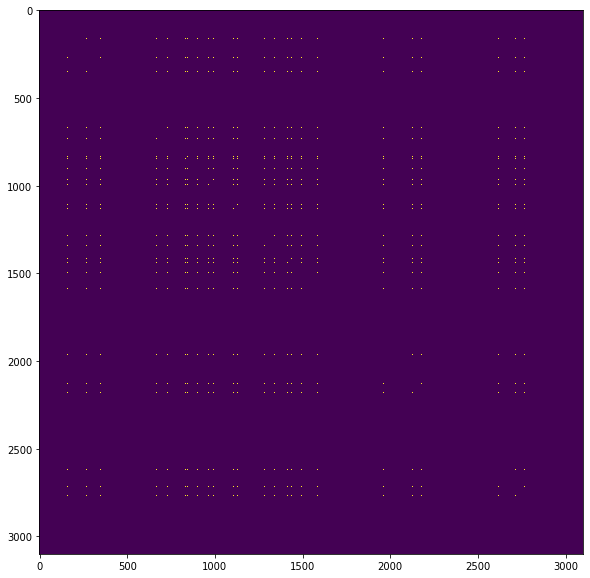

In [197]:
%matplotlib inline
J = torch.Tensor(C)
plt.imshow(((flat_tens*J).T*(flat_tens) != 0))
plt.gcf().set_size_inches(10,10)
print(((flat_tens*J).T*(flat_tens)).sum()/2)

In [149]:
(flat_tens*J*flat_tens.T).sum

tensor(14.1860)

In [132]:
flat_tens.shape, res.shape

(torch.Size([3100]), torch.Size([]))

In [135]:
res

tensor(-6.0383)

In [108]:
evc_model.hamiltonians([t_seq_aa])

array([[691.78837246, 164.79214785, 526.99622461]])

In [222]:
t_seq_aa = focus_seqs.loc[0, 'seq']

In [223]:
print('own function, int seq',hamiltonians(np.asarray([target_seq]), J, h)[0]) # feeding in the integer encoding
print('proper function and aa seq', evc_model.hamiltonians([t_seq_aa])) # feeding in amino acids

own function, int seq [691.78837246 164.79214785 526.99622461]
proper function and aa seq [[691.78837246 164.79214785 526.99622461]]


In [211]:
np.sum(h * t_oh)

526.9962246068753

In [212]:
t_oh.shape

(155, 20)

In [213]:
J.shape

torch.Size([3100, 3100])

In [214]:
np.sum(t_oh_flat)

155.0

In [215]:
(t_oh_flat.T * J * t_oh_flat).shape

TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [216]:
J.shape

torch.Size([3100, 3100])

In [217]:
t_oh_flat.shape

(3100,)

In [218]:
tiled = np.tile(t_oh_flat, 3100)
tiled.shape

(9610000,)

In [219]:
np.sum(tiled.T * J * tiled)#[0].sum()

TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [220]:
t_seq_aa = focus_seqs.loc[0, 'seq']

In [221]:
J = evc_model.J_ij

In [57]:
print('own function, int seq',hamiltonians(np.asarray([target_seq]), J, h)[0]) # feeding in the integer encoding
print('proper function and aa seq', evc_model.hamiltonians([t_seq_aa])) # feeding in amino acids

own function, int seq [691.78837246 164.79214785 526.99622461]
proper function and aa seq [[691.78837246 164.79214785 526.99622461]]


In [ ]:
nat_energies = hamiltonians(enc_seqs, J, h)

In [34]:
nat_energies.shape

(7848, 3)

Plotting a hist of all the natural sequences energies:


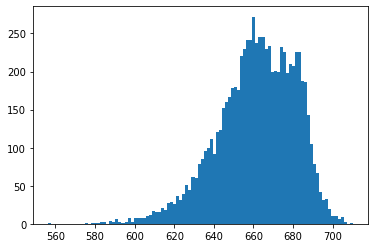

In [35]:
%matplotlib inline
plt.figure()

print('Plotting a hist of all the natural sequences energies:')
plt.hist(nat_energies[:, 0], bins=100)
plt.show()

In [36]:

# E, E_couplings, E_fields = c.hamiltonians([c.seq()])[0]


## We want to minimize protein energy!!! 

In [37]:
gen_model = EVCouplingsGenerator(L, AA, h, J)

In [38]:
from importlib import reload
import PlottingFunctions
reload(PlottingFunctions)
from PlottingFunctions import *

In [39]:
target_seq

array([15,  9,  7,  0,  0,  9,  0, 17,  2, 14, 17,  7,  5, 10,  3, 11,  0,
       10, 12, 18, 11,  9, 12,  0,  2,  9,  0, 18,  4,  8, 14, 11, 16,  9,
       11,  8, 12, 17,  7, 10,  5, 14,  6, 16, 18,  3, 15,  7,  5, 14, 12,
        9, 12,  5, 14,  8, 11,  7,  7,  9, 15, 15, 13, 12,  5, 16,  2,  2,
       14, 17, 16, 18, 17,  8, 15, 17,  2,  3,  0,  7,  0,  0,  1,  5,  2,
       17, 12,  3,  7, 10, 17,  7,  5,  5,  5, 14, 17, 19,  3, 13,  4,  9,
       12,  8,  0, 13,  8,  9, 19,  9, 16,  6,  7,  2,  0,  3, 17,  3,  5,
        2, 16,  6,  4, 12,  2, 19,  3, 12,  2,  2, 18,  3, 15, 17,  4, 15,
        3,  4,  6,  0,  2,  0, 13, 11, 15,  6, 15, 19,  1,  4,  3,  7,  9,
        3, 14])

changing only two amino acid positions: pos1= 5  pos2= 10
(400, 155)
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-682.50725456 -680.79823549 -676.60526634 -680.53654207 -679.66084349
 -680.57129076 -679.33594015 -685.27136327 -679.04486414 -682.42818704
 -680.42128812 -678.58940172 -678.33708031 -680.41840602 -678.52502747
 -679.42651379 -682.20047304 -686.87513825 -679.63878475 -679.68356765
 -683.98233281 -682.49456522 -678.1955908  -682.06709012 -681.26095758
 -682.07625299 -680.93098168 -686.87194619 -680.63899687 -684.10543228
 -681.98700053 -680.19435704 -679.92836345 -682.05028505 -680.11639455
 -681.00177861 -683.81545356 -688.52578529 -681.23376419 -681.28010339
 -678.14196607 -676.52598241 -672.30898338 -676.20282572 -675.38746425
 -676.11862148 -675.0476422  -680.99134056 -674.75520238 -678.20168541
 -676.10779003 -674.29197286 -674.04205038 -676.14739738 -674.23059568
 -675.12440129 -677.92968191 -682.65221113 -675.35029704 -675.39699578
 -682.42212047 -680.74462431 -676

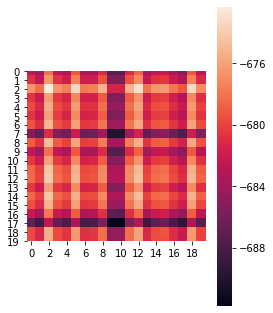

In [40]:
%matplotlib inline
plot_potential(AA_num, target_seq, gen_model.energy, orientation='horizontal', pos1=5, pos2=10)

### MCMC sampling from this - need a sampler that makes discrete proposals

In [41]:
class HardMaxMapper(object):
    def map(self, inp):
        #print('hm inpt', inp.shape)
        # for the markov chain, force all proposals to be in one hot
        if len(inp)>2:
            print('need to handle this!!')
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)
            oh = np.zeros_like(inp)
            #print(inp.shape)
            inp = np.argmax(inp, axis=-1)
            #print('inp here', inp)
            oh[np.arange(oh.shape[0]), inp.flatten()] = 1
            oh = oh.reshape(1, -1)
        #print('res of hard max mapper', oh.shape)
        return oh

In [42]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

nsteps = 1000
# starting positions
I = np.eye(AA_num)

def make_rand_starter():
    rand_starter = []
    for i in range(L):
        rand_starter.append( I[np.random.randint(0,20,1),:] )
    rand_starter = np.asarray(rand_starter).flatten().reshape(1,-1)
    return rand_starter
    
x0_left = make_rand_starter()

x0_right = make_rand_starter()

sampler = MetropolisGauss(gen_model, x0_left, noise=5, 
                          stride=5, mapper=None, is_discrete=True, AA_num=AA_num)
#mapper=HardMaxMapper() but now I have discrete actions so dont need. 
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

the THIS IS IN THE NORMAL ENERGY CALL. ressss [5.99339319]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [6.21971755]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [5.14308531]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [0.11177981]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-1.37283076]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [1.33596669]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [0.85071994]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [0.80627352]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [6.71563495]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [0.41031054]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [3.91698809]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-0.53099452]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-4.43845235]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-4.43845235]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [0.29956651]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-8.88739179]
the THIS IS IN THE NORMAL ENERGY CALL. ressss [-8.5

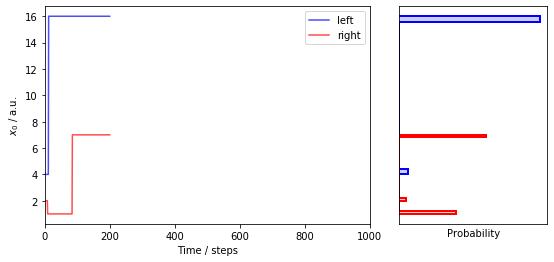

In [43]:
# left is blue
plot_mcmc(traj_left, traj_right, AA_num, pos=0) # pos is for x0 or x1

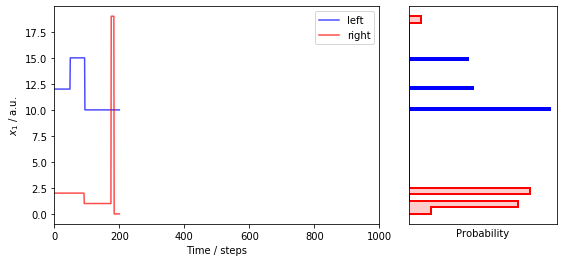

In [44]:
plot_mcmc(traj_left, traj_right, AA_num, pos=1)

the THIS IS IN THE NORMAL ENERGY CALL. ressss [   5.99339319   -1.37283076   -1.37283076   -8.88739179  -19.27579747
  -26.58482558  -28.53211424  -29.09045744  -38.08354645  -44.19895121
  -46.1185278   -46.1185278   -52.21644033  -62.35387515  -64.56120108
  -72.14740988  -82.8810921   -82.66605243  -85.88965854  -84.87866447
  -90.98595128  -91.12809329  -91.12809329  -90.70371293  -92.19954963
  -91.88406954  -94.21140995 -102.04752003 -107.92920819 -106.94998153
 -107.19731769 -114.25424734 -116.48201112 -122.04342932 -126.25330848
 -124.12803088 -126.49426534 -127.74978719 -127.74978719 -129.33381759
 -130.74929061 -130.09609018 -131.15093017 -132.38667493 -140.72263041
 -140.72263041 -139.40437235 -144.01911484 -143.15735632 -160.24664066
 -159.38548369 -156.63870517 -160.77632773 -163.80820567 -161.85033669
 -161.85033669 -166.24981483 -166.59270771 -165.45583207 -167.25090435
 -176.9740352  -178.4687143  -180.27837295 -180.27837295 -184.92172076
 -183.5535586  -184.77078145 -1

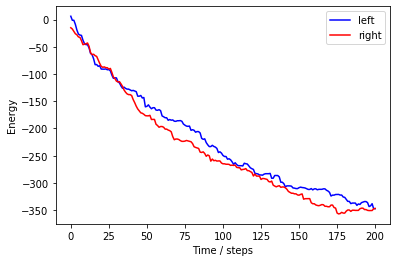

In [45]:
# because of the discreet space, it is too hard to move? 
# reward for the blue line,
# the energy states present in over time
plt.plot(np.arange(traj_left.shape[0]), gen_model.energy(traj_left), color='blue', label='left')
plt.plot(np.arange(traj_right.shape[0]), gen_model.energy(traj_right), color='red', label='right')
plt.ylabel('Energy')
plt.xlabel('Time / steps')
plt.legend()

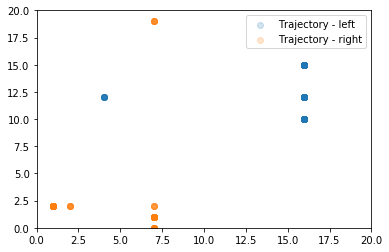

In [46]:
both_traj = [traj_left, traj_right]
names = ['left', 'right']
for ind, traj in enumerate(both_traj):
    x0 = vect_to_aa_ind(traj, AA_num=AA_num,pos=0)
    x1 = vect_to_aa_ind(traj, AA_num=AA_num,pos=1)
    plt.scatter(x0,x1, alpha=0.2, label='Trajectory - ' + names[ind] )
    
plt.xlim([0,20])
plt.ylim([0,20])
plt.legend()

In [58]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [59]:
x = traj_left[-50:,:]
xval= traj_left[-50:,:]

## NVP

In [60]:
epochsZ = 1
epochsE = 100
batchsize_ML = 128
batchsize_KL = 1000
temperature = 1.0
explore = 1.0

In [61]:
gen_model.dim

3100

In [62]:
from importlib import reload

import EVCouplingsGen
reload(EVCouplingsGen)
from EVCouplingsGen import *

In [63]:
gen_model = EVCouplingsGenerator(L, AA, h, J)

In [65]:
network_RNVP_KLML = invnet(gen_model.dim, 'NNNNS', gen_model, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 3100 0 0
N 1550 1550 0
N 1550 1550 0
N 1550 1550 0
N 1550 1550 0
> 1550 1550 0
S 3100 0 0
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
network_RNVP_KLML1 = network_RNVP_KLML.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                                               verbose=1, return_test_energies=False)

Instructions for updating:
Use tf.cast instead.


In [ ]:
# this for loop is super super slow in tensorflow. 
# wish there was a way to do matrix multiplication. But really just need
# to be able to extract these tensors. 

network_RNVP_KLML2 = network_RNVP_KLML.train_flexible(x, xval=xval, lr=0.000001, epochs=epochsE, batch_size=batchsize_KL, 
                                                     std=1.0,
                                                     weight_ML=0.001, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                     weight_RCEnt=0.0,
                                                     temperature=temperature, explore=explore, verbose=1,
                                                     return_test_energies=False, is_discrete=True)

dimensions of hte input to discrete (?, 3100)
result of the int arg max Tensor("loss_6/index_layer_18_loss/loss_KL_disc/Reshape_1:0", shape=(1000, 155), dtype=int32)
GIANT TURDS!!!???
result of EVH! and hamiltonian! [<tf.Tensor 'loss_6/index_layer_18_loss/loss_KL_disc/PyFunc:0' shape=<unknown> dtype=float64>]
set to be a constant! Tensor("loss_6/index_layer_18_loss/loss_KL_disc/Squeeze:0", shape=(1000,), dtype=float32)
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_depende

In [ ]:
plot_convergence(network_RNVP_KLML1, network_RNVP_KLML2, 0, 2)

In [47]:
# want the trajectories to be in the high probability regions. 

'''# transition energy barrier which is approx across point 15.
ts_n=1000
I = np.eye(AA_num)
# want the barrier to be at x_0 = 15
x_z = np.repeat( np.expand_dims(I[15,:], 0), ts_n, axis=0)

# random x_1 values
rand_x_1 = I[np.random.randint(0,AA_num, ts_n),:]

x_ts = np.hstack([x_z, rand_x_1])
x_ts.shape'''

'# transition energy barrier which is approx across point 15.\nts_n=1000\nI = np.eye(AA_num)\n# want the barrier to be at x_0 = 15\nx_z = np.repeat( np.expand_dims(I[15,:], 0), ts_n, axis=0)\n\n# random x_1 values\nrand_x_1 = I[np.random.randint(0,AA_num, ts_n),:]\n\nx_ts = np.hstack([x_z, rand_x_1])\nx_ts.shape'

In [48]:
#fig, axes = plot_network(network_RNVP_KLML, traj_left, traj_right, x_ts, AA_num, model, weight_cutoff=1e-2);

# both of the plots on the right should have orange on them. 

In [49]:
sample_z, sample_x, energy_z, energy_x, log_w = network_RNVP_KLML.sample(temperature=1.0, nsample=10000)

NameError: name 'network_RNVP_KLML' is not defined

In [ ]:
plt.hist(energy_x)

In [ ]:
x0 = vect_to_aa_ind(sample_x, AA_num=AA_num,pos=0)
x1 = vect_to_aa_ind(sample_x, AA_num=AA_num,pos=1)

In [ ]:
plt.scatter(x0,x1, alpha=0.2)
plt.xlim([0,20])
plt.ylim([0,20])

In [ ]:
plt.hist(x0)
plt.show()
plt.hist(x1)

## Nicer Network

In [35]:
epochsZ = 200
epochsE = 500
batchsize_ML = 128
batchsize_KL = 1000
temperature = 1.0
explore = 1.0

In [36]:
network_NICER_KLML = invnet(model.dim, 'NNNNS', model, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 42 0 0
N 21 21 0
N 21 21 0
N 21 21 0
N 21 21 0
> 21 21 0
S 42 0 0
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'log_scale:0' shape=(1, 42) dtype=float32> log_scaling_factors
tracking <tf.Variable 'log_scale:0' shape=(1, 42) dtype=float32> log_scaling_factors


In [37]:
hist_NICER_KLML1 = network_NICER_KLML.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                                               verbose=0, return_test_energies=True)

hist_NICER_KLML2 = network_NICER_KLML.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=batchsize_KL, 
                                                     std=1.0,
                                                     weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                                     weight_RCEnt=0.0,
                                                     temperature=temperature, explore=explore, verbose=0,
                                                     return_test_energies=True)

Instructions for updating:
Use tf.cast instead.
energy tf giong in  Tensor("index_layer_6/GatherV2:0", shape=(?, 42), dtype=float32)
energy calc done, 1xbatch size?  Tensor("loss_1/index_layer_6_loss/loss_KL/Sum:0", shape=(?,), dtype=float32)


(<Figure size 360x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1196c1908>,
       dtype=object))

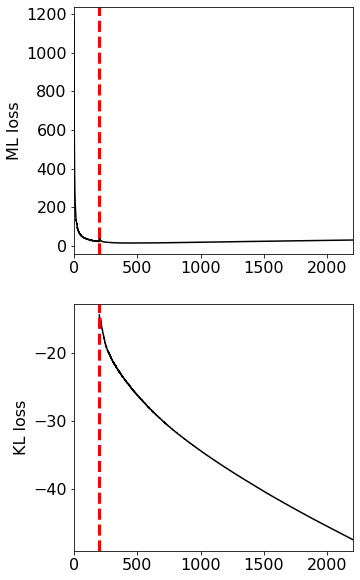

In [38]:
plot_convergence(hist_NICER_KLML1, hist_NICER_KLML2, 0, 2)

In [39]:
# want the trajectories to be in the high probability regions. 

# transition energy barrier 
ts_n=1000
I = np.eye(AA_num)
x_z = np.repeat( np.expand_dims(I[15,:], 0), ts_n, axis=0)

rand_x_o = I[np.random.randint(0,AA_num, ts_n),:]

x_ts = np.hstack([x_z, rand_x_o])
x_ts.shape

(1000, 42)

/Users/trentonbricken/protein-generators/notebooks/PlottingFunctions.py:108: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature


(21, 21)
[-27.32675736 -26.66489972 -30.20641129 ... -25.3841614  -35.4018804
 -21.26360066]


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/Deep_Boltzmann_Package-0.1-py3.7.egg/deep_boltzmann/sampling/analysis.py:116: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  1.1547669703791767
(21, 21)


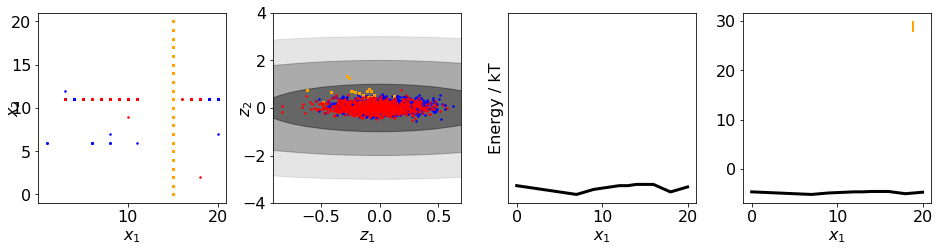

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [41]:
fig, axes = plot_network(network_NICER_KLML, traj_left, traj_right, x_ts, AA_num, model, weight_cutoff=1e-2);

In [ ]:
plot_all_zs()

In [42]:
sample_z, sample_x, energy_z, energy_x, log_w = network_NICER_KLML.sample(temperature=1.0, nsample=100000)

In [43]:
x0 = vect_to_aa_ind(sample_x, AA_num=AA_num,pos=0)
x1 = vect_to_aa_ind(sample_x, AA_num=AA_num,pos=1)

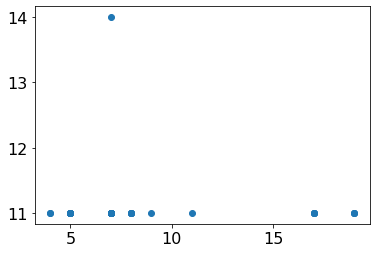

In [44]:
plt.scatter(x0,x1, alpha=0.2)